Idea from https://towardsdatascience.com/spam-classifier-in-python-from-scratch-27a98ddd8e73

Code taken and adapted from https://github.com/tejank10/Spam-or-Ham/blob/master/spam_ham.ipynb

In [35]:
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from math import log, sqrt
import pandas as pd
import numpy as np
import re
%matplotlib inline

from sklearn.model_selection import train_test_split

In [3]:
troll_df = pd.read_csv("data/troll_data_2016.csv", index_col="Unnamed: 0")
troll_df.head()

,external_author_id,author,content,region,language,publish_date,harvested_date,following,followers,updates,post_type,account_type,new_june_2018,retweet,account_category
2050,1.504356e+09,GALLOWAYELIANA,"Ever so slowly, the euro zone economy awakes: ...",United States,English,1/10/2016 12:20,1/10/2016 12:20,719,291,910,RETWEET,left,0,1,LeftTroll
2051,1.504356e+09,GALLOWAYELIANA,Children's books in ATL https://t.co/KeVdp54kyf,United States,English,1/10/2016 12:20,1/10/2016 12:20,719,291,911,RETWEET,left,0,1,LeftTroll
2052,1.504356e+09,GALLOWAYELIANA,Judge Olu Stevens jails White man for calling ...,United States,English,1/10/2016 12:20,1/10/2016 12:20,719,291,908,RETWEET,left,0,1,LeftTroll
2053,1.504356e+09,GALLOWAYELIANA,"How you dress should not invite lewdness, hara...",United States,English,1/11/2016 16:42,1/11/2016 16:42,720,289,912,RETWEET,left,0,1,LeftTroll
2054,1.504356e+09,GALLOWAYELIANA,Why Do We Need Activism? https://t.co/iKof0c...,United States,English,1/11/2016 16:42,1/11/2016 16:42,720,289,913,RETWEET,left,0,1,LeftTroll


In [4]:
troll_df["is_troll"] = 1

In [5]:
troll_df.head()

,external_author_id,author,content,region,language,publish_date,harvested_date,following,followers,updates,post_type,account_type,new_june_2018,retweet,account_category,is_troll
2050,1.504356e+09,GALLOWAYELIANA,"Ever so slowly, the euro zone economy awakes: ...",United States,English,1/10/2016 12:20,1/10/2016 12:20,719,291,910,RETWEET,left,0,1,LeftTroll,1
2051,1.504356e+09,GALLOWAYELIANA,Children's books in ATL https://t.co/KeVdp54kyf,United States,English,1/10/2016 12:20,1/10/2016 12:20,719,291,911,RETWEET,left,0,1,LeftTroll,1
2052,1.504356e+09,GALLOWAYELIANA,Judge Olu Stevens jails White man for calling ...,United States,English,1/10/2016 12:20,1/10/2016 12:20,719,291,908,RETWEET,left,0,1,LeftTroll,1
2053,1.504356e+09,GALLOWAYELIANA,"How you dress should not invite lewdness, hara...",United States,English,1/11/2016 16:42,1/11/2016 16:42,720,289,912,RETWEET,left,0,1,LeftTroll,1
2054,1.504356e+09,GALLOWAYELIANA,Why Do We Need Activism? https://t.co/iKof0c...,United States,English,1/11/2016 16:42,1/11/2016 16:42,720,289,913,RETWEET,left,0,1,LeftTroll,1


In [6]:
non_troll_df = pd.read_csv("data/non_troll_data_simplified.csv", index_col="Unnamed: 0")
non_troll_df.head()

C:\Users\Julien\Miniconda3\envs\py36\lib\site-packages\IPython\core\interactiveshell.py:2785: DtypeWarning: Columns (0,1,3,4,7,8,9,10,11,12) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,created_at,id,is_quote_status,lang,possibly_sensitive,retweet_count,retweeted,scopes,source,text,truncated,withheld_in_countries,followers,following,is_a_retweet
603148,2016-11-08 16:58:18,7.960341e+17,False,en,0.0,50924.0,False,NaN,"<a href=""http://twitter.com/download/iphone"" r...",RT @HillaryClinton: Don't stand still. Vote to...,False,NaN,387.0,NaN,True
603149,2016-11-08 22:34:35,7.961188e+17,False,es,0.0,229.0,False,NaN,"<a href=""http://twitter.com"" rel=""nofollow"">Tw...",RT @Javierito321: Yo si gana Trump / Yo si gan...,False,NaN,685.0,NaN,True
603150,2016-11-09 07:29:33,7.962534e+17,False,en,NaN,11903.0,False,NaN,"<a href=""http://twitter.com/download/iphone"" r...",RT @MisElizaJane: This is how #the100 would ha...,False,NaN,1551.0,NaN,True
603151,2016-11-09 05:07:27,7.962176e+17,False,es,NaN,2111.0,False,NaN,"<a href=""http://twitter.com/download/iphone"" r...",RT @MiPatanFavorito: Elecciones EUA:\n2008: Pr...,False,NaN,526.0,NaN,True
603152,2016-11-08 18:52:19,7.960628e+17,False,en,0.0,167.0,False,NaN,"<a href=""http://twitter.com"" rel=""nofollow"">Tw...",RT @FiveThirtyEight: More than eight in 10 Ame...,False,NaN,94.0,NaN,True


In [7]:
non_troll_df["is_troll"] = 0

In [8]:
non_troll_df = non_troll_df.rename(columns={"text": "content"})

In [9]:
non_troll_df.shape[0]

1378909

In [10]:
troll_df.shape[0] + non_troll_df.shape[0]

1776068

In [12]:
full_df = pd.concat((troll_df[["content", "is_troll"]],
                     non_troll_df[["content", "is_troll"]]))

In [13]:
full_df.shape[0]

1776068

In [18]:
non_troll_df[non_troll_df["content"].isnull()].shape[0]

243051

In [19]:
non_troll_df.shape[0]

1378909

In [20]:
full_df[full_df.content.isnull()].head()

,content,is_troll
#ElectionNight #ElectionDay https://t.co/NJcXl8A8tB,NaN,0
#ElectionDay,NaN,0
#ElectionNight #ElectionDay,NaN,0
يبقى مش هتعمر فيها 😂😂 https://t.co/ZPzdbaMlxx,NaN,0
Me: Gassy and anxious.,NaN,0


In [21]:
full_df.shape[0]

1776068

In [22]:
full_df = full_df[full_df.content.notnull()]

In [23]:
full_df.shape[0]

1533017

In [24]:
full_df.is_troll.value_counts()

0    1135858
1     397159
Name: is_troll, dtype: int64

In [28]:
non_troll_df_undersampled = non_troll_df[non_troll_df.content.notnull()].sample(n=full_df[full_df.is_troll == 1].shape[0], random_state=123)

In [33]:
full_df = pd.concat((troll_df[["content", "is_troll"]],
                     non_troll_df_undersampled[["content", "is_troll"]]))

In [34]:
full_df.is_troll.value_counts()

1    397159
0    397159
Name: is_troll, dtype: int64

In [38]:
full_df.shape

(794318, 2)

In [39]:
full_df.head()

,content,is_troll
2050,"Ever so slowly, the euro zone economy awakes: ...",1
2051,Children's books in ATL https://t.co/KeVdp54kyf,1
2052,Judge Olu Stevens jails White man for calling ...,1
2053,"How you dress should not invite lewdness, hara...",1
2054,Why Do We Need Activism? https://t.co/iKof0c...,1


In [43]:
full_df.reset_index(drop=True, inplace=True)

In [45]:
full_df.head()

,content,is_troll
0,"Ever so slowly, the euro zone economy awakes: ...",1
1,Children's books in ATL https://t.co/KeVdp54kyf,1
2,Judge Olu Stevens jails White man for calling ...,1
3,"How you dress should not invite lewdness, hara...",1
4,Why Do We Need Activism? https://t.co/iKof0c...,1


In [51]:
train_df, test_df = train_test_split(full_df, test_size=.2, random_state=123)

In [61]:
def create_word_cloud(is_troll_label):
    words = ' '.join(full_df[full_df.is_troll == is_troll_label].content.values)
    wc = WordCloud(width = 512,height = 512).generate(words)
    plt.figure(figsize = (10, 8), facecolor = 'k')
    plt.imshow(wc)
    plt.axis('off')
    plt.tight_layout(pad = 0)
    plt.show()

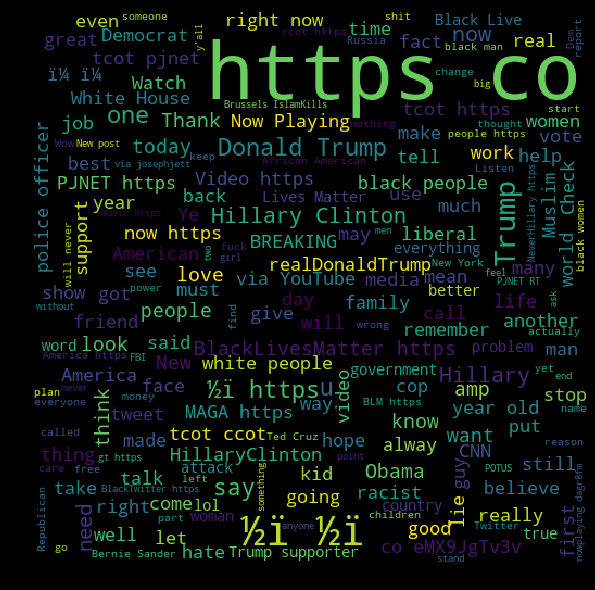

Wall time: 1min 3s


In [62]:
%%time
create_word_cloud(is_troll_label=1)

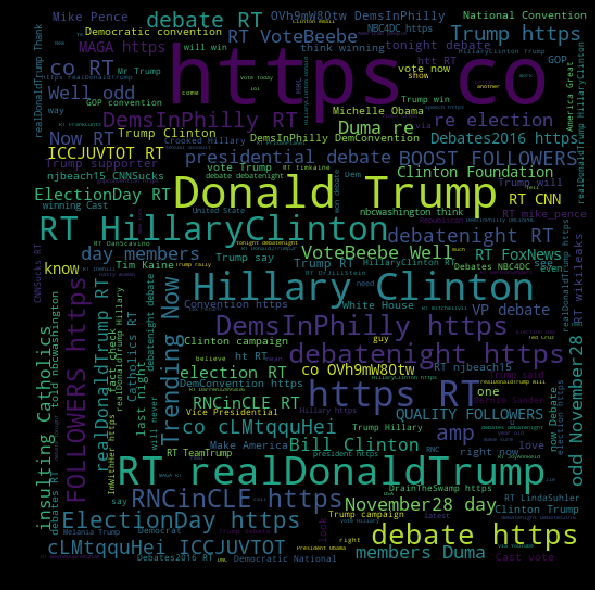

Wall time: 56.5 s


In [63]:
%%time
create_word_cloud(is_troll_label=0)

In [64]:
def process_message(message, lower_case = True, stem = True, stop_words = True, gram = 2):
    if lower_case:
        message = message.lower()
    words = word_tokenize(message)
    words = [w for w in words if len(w) > 2]
    if gram > 1:
        w = []
        for i in range(len(words) - gram + 1):
            w += [' '.join(words[i:i + gram])]
        return w
    if stop_words:
        sw = stopwords.words('english')
        words = [word for word in words if word not in sw]
    if stem:
        stemmer = PorterStemmer()
        words = [stemmer.stem(word) for word in words]   
    return words

In [84]:
class TrollClassifier:
    def __init__(self, train_data, method='tf-idf'):
        self.mails, self.labels = train_data['content'].reset_index(drop=True), train_data['is_troll'].reset_index(drop=True)
        self.method = method

    def train(self):
        self.calc_TF_and_IDF()
        if self.method == 'tf-idf':
            self.calc_TF_IDF()
        else:
            self.calc_prob()

    def calc_prob(self):
        self.prob_troll = dict()
        self.prob_non_troll = dict()
        for word in self.tf_troll:
            self.prob_troll[word] = (self.tf_troll[word] + 1) / (self.troll_words + \
                                                                len(list(self.tf_troll.keys())))
        for word in self.tf_non_troll:
            self.prob_non_troll[word] = (self.tf_non_troll[word] + 1) / (self.non_troll_words + \
                                                                len(list(self.tf_non_troll.keys())))
        self.prob_troll_mail, self.prob_non_troll_mail = self.troll_mails / self.total_mails, self.non_troll_mails / self.total_mails 


    def calc_TF_and_IDF(self):
        noOfMessages = self.mails.shape[0]
        self.troll_mails, self.non_troll_mails = self.labels.value_counts()[1], self.labels.value_counts()[0]
        self.total_mails = self.troll_mails + self.non_troll_mails
        self.troll_words = 0
        self.non_troll_words = 0
        self.tf_troll = dict()
        self.tf_non_troll = dict()
        self.idf_troll = dict()
        self.idf_non_troll = dict()
        for i in range(noOfMessages):
            message_processed = process_message(self.mails.values[i])
            count = list() #To keep track of whether the word has ocured in the message or not.
                           #For IDF
            for word in message_processed:
                if self.labels.values[i]:
                    self.tf_troll[word] = self.tf_troll.get(word, 0) + 1
                    self.troll_words += 1
                else:
                    self.tf_non_troll[word] = self.tf_non_troll.get(word, 0) + 1
                    self.non_troll_words += 1
                if word not in count:
                    count += [word]
            for word in count:
                if self.labels[i]:
                    self.idf_troll[word] = self.idf_troll.get(word, 0) + 1
                else:
                    self.idf_non_troll[word] = self.idf_non_troll.get(word, 0) + 1

    def calc_TF_IDF(self):
        self.prob_troll = dict()
        self.prob_non_troll = dict()
        self.sum_tf_idf_troll = 0
        self.sum_tf_idf_non_troll = 0
        for word in self.tf_troll:
            self.prob_troll[word] = (self.tf_troll[word]) * log((self.troll_mails + self.non_troll_mails) \
                                                          / (self.idf_troll[word] + self.idf_non_troll.get(word, 0)))
            self.sum_tf_idf_troll += self.prob_troll[word]
        for word in self.tf_troll:
            self.prob_troll[word] = (self.prob_troll[word] + 1) / (self.sum_tf_idf_troll + len(list(self.prob_troll.keys())))
            
        for word in self.tf_non_troll:
            self.prob_non_troll[word] = (self.tf_non_troll[word]) * log((self.troll_mails + self.non_troll_mails) \
                                                          / (self.idf_troll.get(word, 0) + self.idf_non_troll[word]))
            self.sum_tf_idf_non_troll += self.prob_non_troll[word]
        for word in self.tf_non_troll:
            self.prob_non_troll[word] = (self.prob_non_troll[word] + 1) / (self.sum_tf_idf_non_troll + len(list(self.prob_non_troll.keys())))
            
    
        self.prob_troll_mail, self.prob_non_troll_mail = self.troll_mails / self.total_mails, self.non_troll_mails / self.total_mails 
                    
    def classify(self, processed_message):
        ptroll, pnon_troll = 0, 0
        for word in processed_message:                
            if word in self.prob_troll:
                ptroll += log(self.prob_troll[word])
            else:
                if self.method == 'tf-idf':
                    ptroll -= log(self.sum_tf_idf_troll + len(list(self.prob_troll.keys())))
                else:
                    ptroll -= log(self.troll_words + len(list(self.prob_troll.keys())))
            if word in self.prob_non_troll:
                pnon_troll += log(self.prob_non_troll[word])
            else:
                if self.method == 'tf-idf':
                    pnon_troll -= log(self.sum_tf_idf_non_troll + len(list(self.prob_non_troll.keys()))) 
                else:
                    pnon_troll -= log(self.non_troll_words + len(list(self.prob_non_troll.keys())))
            ptroll += log(self.prob_troll_mail)
            pnon_troll += log(self.prob_non_troll_mail)
        return ptroll >= pnon_troll
    
    def predict(self, testData):
        result = dict()
        for (i, message) in enumerate(testData):
            processed_message = process_message(message)
            result[i] = int(self.classify(processed_message))
        return result

In [93]:
def metrics(labels, predictions):
    labels = labels.values
    predictions = predictions.values
    true_pos, true_neg, false_pos, false_neg = 0, 0, 0, 0
    for i in range(len(labels)):
        true_pos += int(labels[i] == 1 and predictions[i] == 1)
        true_neg += int(labels[i] == 0 and predictions[i] == 0)
        false_pos += int(labels[i] == 0 and predictions[i] == 1)
        false_neg += int(labels[i] == 1 and predictions[i] == 0)
#     precision = true_pos / (true_pos + false_pos)
#     recall = true_pos / (true_pos + false_neg)
#     Fscore = 2 * precision * recall / (precision + recall)
    accuracy = (true_pos + true_neg) / (true_pos + true_neg + false_pos + false_neg)

#     print("Precision: ", precision)
#     print("Recall: ", recall)
#     print("F-score: ", Fscore)
    print("Accuracy: ", accuracy)

In [71]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Julien\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt.zip.


True

In [96]:
from sklearn.metrics import accuracy_score

In [123]:
subsample = 2000
train_df_subsampled = train_df.sample(subsample)
test_df_subsampled = test_df.sample(subsample)
train_df_subsampled.is_troll.value_counts()
test_df_subsampled.is_troll.value_counts()

0    1013
1     987
Name: is_troll, dtype: int64

In [124]:
%%time
sc_bow = TrollClassifier(train_df_subsampled, 'bow')
sc_bow.train()
preds_bow = sc_bow.predict(test_df_subsampled['content'])
preds_bow_train = sc_bow.predict(train_df_subsampled['content'])
print("Train accuracy is {}".format(accuracy_score(train_df_subsampled['is_troll'], list(preds_bow_train.values()))))
print("Test accuracy is {}".format(accuracy_score(test_df_subsampled['is_troll'], list(preds_bow.values()))))

Train accuracy is 0.993
Test accuracy is 0.596
Wall time: 22.1 s


In [125]:
%%time
sc_bow = TrollClassifier(train_df_subsampled, 'tf-idf')
sc_bow.train()
preds_bow = sc_bow.predict(test_df_subsampled['content'])
preds_bow_train = sc_bow.predict(train_df_subsampled['content'])
print("Train accuracy is {}".format(accuracy_score(train_df_subsampled['is_troll'], list(preds_bow_train.values()))))
print("Test accuracy is {}".format(accuracy_score(test_df_subsampled['is_troll'], list(preds_bow.values()))))

Train accuracy is 0.993
Test accuracy is 0.591
Wall time: 21.9 s
